In [58]:
import importlib
import functions.eda as eda
importlib.reload(eda)

import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import random

In [59]:
dataset = eda.load_parquet('data/processed/ml_ready.parquet')
dataset = dataset[dataset['timestamp'] > '2024-01-01']

Loaded data/processed/ml_ready.parquet. Shape: (430715, 15)


In [ ]:
def sanitize_float_list_to_null(lst):
    return [None if pd.isna(v) or not np.isfinite(v) else float(v) for v in lst]

def sanitize_scalar_to_null(val):
    return None if pd.isna(val) or not np.isfinite(val) else float(val)

def make_prediction(series_instrument, series_index, random_row):
    
    json_data = {
        "series": sanitize_float_list_to_null(series_instrument),
        "series_index": sanitize_float_list_to_null(series_index),
        "open": sanitize_scalar_to_null(random_row["open"]),
        "high": sanitize_scalar_to_null(random_row["high"]),
        "low": sanitize_scalar_to_null(random_row["low"]),
        "close": sanitize_scalar_to_null(random_row["close"]),
        "open_index": sanitize_scalar_to_null(random_row["open_index"]),
        "high_index": sanitize_scalar_to_null(random_row["high_index"]),
        "low_index": sanitize_scalar_to_null(random_row["low_index"]),
        "close_index": sanitize_scalar_to_null(random_row["close_index"]),
        "corr_30h": sanitize_scalar_to_null(random_row["corr_30h"]),
        "corr_60h": sanitize_scalar_to_null(random_row["corr_60h"]),
    }

    response = requests.post("http://127.0.0.1:8001/predict", json=json_data) # change to the correct port

    print("Status:", response.status_code)
    print("Text:", response.text)

    try:
        return response.json()
    except Exception as e:
        print(f"Error: {e}")
        return None

Status: 200
Text: {"status":"ok","prediction":[143.14405822753906,143.1802978515625,143.20065307617188,143.27548217773438,143.21144104003906,143.2767333984375,143.32615661621094,143.721435546875,143.61122131347656,143.6981658935547,143.7315216064453,143.7227020263672,144.30728149414062,144.07931518554688,144.38531494140625,144.14295959472656,144.153564453125,144.13275146484375,144.15997314453125,144.03627014160156,144.04049682617188,144.07022094726562,143.6697540283203,143.6582489013672,143.63026428222656,143.83663940429688,143.6901092529297,143.69027709960938,143.7406463623047,143.7081756591797,143.75186157226562,143.70233154296875,143.69827270507812,143.39138793945312,143.509033203125,143.5606689453125,143.55661010742188,143.5554962158203,143.55343627929688,143.5293426513672,143.5542755126953,143.693115234375,143.709228515625,143.62796020507812,143.59765625,143.53872680664062,143.46641540527344,143.382080078125,143.3841552734375,143.49639892578125,143.42857360839844,143.4639739990234

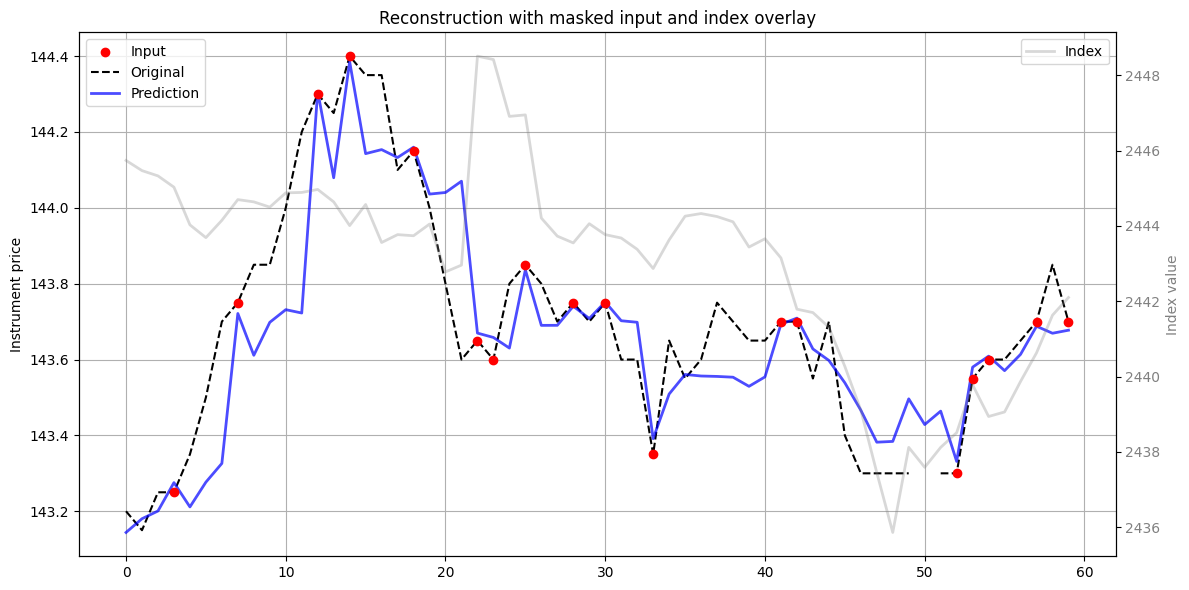

In [147]:
masking_fraction = 0.7

import random
import numpy as np
import matplotlib.pyplot as plt

# 1. Sample a random example
random_row = dataset.sample(1).iloc[0]
original_series = random_row["series"]
original_index = random_row["series_index"]

# 2. Mask part of the series
def mask_random_points(series, mask_fraction=0.5):
    series = np.array(series, dtype=np.float32)
    known_indices = np.where(np.isfinite(series))[0]
    n_to_mask = int(len(known_indices) * mask_fraction)
    indices_to_mask = np.random.choice(known_indices, size=n_to_mask, replace=False)
    series_masked = series.copy()
    series_masked[indices_to_mask] = np.nan
    return series_masked

masked_series = mask_random_points(original_series, mask_fraction=masking_fraction)

# 3. Send to API
prediction_result = make_prediction(masked_series, original_index, random_row)
prediction = prediction_result["prediction"] if prediction_result and "prediction" in prediction_result else None

# 4. Plot
if prediction is not None:
    x = np.arange(len(original_series))
    input_mask = np.isfinite(masked_series)

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.scatter(x[input_mask], masked_series[input_mask], color='red', label='Input', zorder=5)
    ax1.plot(x, original_series, color='black', linestyle='--', label='Original')
    ax1.plot(x, prediction, color='blue', linewidth=2, alpha=0.7, label='Prediction')

    ax1.set_ylabel("Instrument price")
    ax1.legend(loc='upper left')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(x, original_index, color='gray', alpha=0.3, linestyle='-', linewidth=2, label='Index')
    ax2.set_ylabel("Index value", color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')
    ax2.legend(loc='upper right')

    plt.title("Reconstruction with masked input and index overlay")
    plt.tight_layout()
    plt.show()
else:
    print("Prediction missing")